In [1]:
!pip install cplex
!pip install docplex

     |████████████████████████████████| 43.3 MB 18 kB/s 
     |████████████████████████████████| 610 kB 8.6 MB/s 
  Created wheel for docplex: filename=docplex-2.23.222-py3-none-any.whl size=662847 sha256=c5d7ad6fe8cb86a8611f5ff9f1da9d117c6e505fdb99276b2030355632ddfdcb
  Stored in directory: /root/.cache/pip/wheels/a7/c9/fb/cee5a89f304e77a39c466e625ac2830434b76eb8384999d116
Successfully built docplex


In [2]:
import matplotlib.pyplot as plt
import docplex.mp.model as md
from itertools import permutations
import numpy as np
import time
import random

In [ ]:
'''
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.facecolor'] = '#030303'
plt.rcParams['figure.facecolor'] = '#030303'
'''

"\nplt.style.use('classic')\nplt.rcParams['figure.figsize'] = [10, 10]\nplt.rcParams['axes.facecolor'] = '#030303'\nplt.rcParams['figure.facecolor'] = '#030303'\n"

The Hamiltonian we are seeking to minimize can be written as $$H_{pair}=\sum_i \left(1 - \sum_j x_{ij} \right)^2 + \sum_j \left(1- \sum_i x_{ij} \right)^2+\sum_{ij, i \neq j} A_{ij} \left(\sum_n x_{ij,first} x_{ij,second} \right)+ \sum_{p,first} \sum_{i,first} x_{ip} W_{ip} + \sum_{p,second} \sum_{i,second} x_{ip} W_{ip} $$ where $i,j,n$ are position indices and $p$ is a location index. The first two terms ensure one-one matching. The third term is checking the affinity (average of weights for each pair decision, i.e. $A_{ij} = \frac{W_{ij,first} + W_{ij, second}}{2}$ of every possible pair. The fourth and fifth terms are the usual weighting of each pair.

In [ ]:
# Set random seed
np.random.seed(45)
# Define Number of Pairs to be Matched
n,m=10,10
k=3
y=np.linspace(1,n,n,dtype=int)
# Create random array of random combinations of the 10 indices ordered
# for the first group's preferences:
first = np.array([random.sample(list(permutations(y,n)),n)]).reshape(n,n)
# second group's preferences:
# Transpose ensures that they order down rather than across (no repeats in columns of matrix)
second = np.array([random.sample(list(permutations(np.linspace(1,n,n,dtype=int),n)),n)]).reshape(n,n).transpose()
match=md.Model(name='Matching')
x=np.array(match.binary_var_list(n**2)).reshape(n,n)
H1 = np.sum([ [ (np.sum(x[i,:])-1)**2 ] for i in range(n)])*99
H2 = np.sum([ [ (np.sum(x[:,j])-1)**2 ] for j in range(n)])*99
H3 = np.sum([ [ x[i,j]*(first[i,j]+second[i,j]) ] for i in range(n) for j in range(n)])
H4 = np.sum([ [ x[i,j]*x[k,l]*(first[i,j]+second[k,l])/2 ] for i in range(n) for j in range(n) for k in range(n) for l in range(n) if i!=k and j!=l  ])
match.minimize(H1+H2+H3+H4)
solution = np.array(match.solve().get_value_list(x.flatten())).reshape(n,n)
print(solution)
count=0
for i in range(n):
  for j in range(n):
    for k in range(n):
      for l in range(n):
        if first[i,j]<first[i,k] and second[i,j]<second[l,j] and solution[i,j]==1 and solution[l,k]:
          print(i,j)
          count+=1
print(count)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
0 5
0 5
0 5
0 5
0 5
0 5
0 5
0 5
0 5
0 5
0 5
0 5
2 6
2 6
2 6
3 1
3 1
5 4
5 4
5 4
9 3
9 3
9 3
23


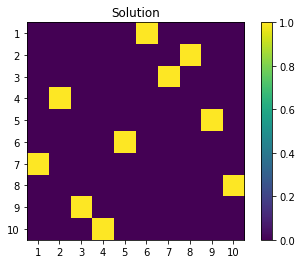

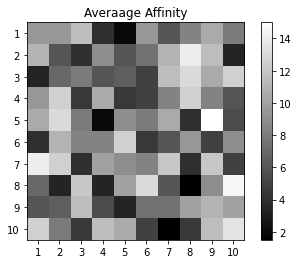

In [ ]:
plt.imshow(solution, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],y)
plt.xticks([i for i in range(n)],y)
plt.title('Solution')
plt.colorbar()
plt.show()

plt.imshow(first+second/2, interpolation='nearest',cmap='gray')
plt.yticks([i for i in range(n)],y)
plt.xticks([i for i in range(n)],y)
plt.title('Averaage Affinity')
plt.colorbar()
plt.show()